In [1]:
import sys
sys.version

'3.7.5 (default, Nov  7 2019, 10:50:52) \n[GCC 8.3.0]'

# Chapter 9 - Hierarchical Models

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
from matplotlib import cm  # color map
import seaborn as sns
sns.set()

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
%load_ext watermark
%watermark -p pandas,numpy,pymc3,matplotlib,seaborn

pandas    : 1.2.1
numpy     : 1.19.5
pymc3     : 3.11.0
matplotlib: 3.3.3
seaborn   : 0.11.1



## Chapter 9.1 A Single Coin from a Single Mint

In [4]:
# observation: three Heads and 
y = np.zeros(12); 
y[:9] = 1  # Heads
y

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.])

### Posterior via grid-approximation

- Prior: 
    $$
        w \sim Beta(Aw, Bw) \\
        K = 100 \\
        p(\theta, \omega) = Beta(\theta|a(\omega), b(\omega)) Beta(\omega|A_\omega, B_\omega)
    $$
    - Domain of beta() is approximated with grid
- Likelihood:
    $$
        y_i \sim Bernoulli(\theta) \\
        p(y_i | \theta) = \theta^{y_i} (1 - \theta)^{1-y_i}
    $$
- Posterior:
    $$
        p(\theta, \omega| Y) \approx  p(\theta|a, b) p(\omega|A_w, B_w) \prod_{i=1}^n p(y_i|\theta) \\
        = p(\theta, \omega) \prod_{i=1}^n p(y_i|\theta) 
    $$

* The probability densities are all approximated as mass functions at the grid points.

In [5]:
grid = np.linspace(0, 1, 100)

#### Prior Distributioins

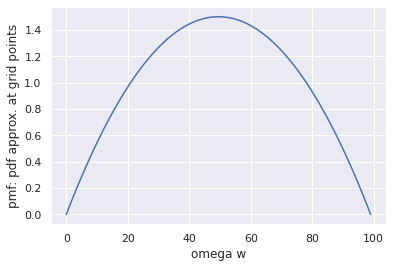

In [6]:
# hyper-prior: prior of prior
Aw, Bw = 2, 2
pdf_w = stats.beta(a=Aw, b=Bw).pdf(grid)

# hyper-prior for K, chosen as a constant 
K = 100

# plot
plt.xlabel('omega w')
plt.ylabel('pmf: pdf approx. at grid points')
plt.plot(pdf_w);

Prior: $\theta$ is determined as a sample from $p(\omega)$

In [7]:
# p(th, w) = p(th|w)p(w)
# p(th|w) = beta(w(K-2)+1, (1-w)(K-2)+1)
pdf_t_given_w = []  # conditionals; arrary of p(th|w) at w's
pdf_tw = []  # joint pdf p(th, w) = p(th|w) * p(w)
for iw, w in enumerate(grid):
    a, b = w*(K-2)+1, (1-w)*(K-2)+1  # (a,b) is determined at (w, K) 
    pdf_t_given_w_at_w = stats.beta(a,b).pdf(grid)
    
    pdf_t_given_w.append(pdf_t_given_w_at_w)
    pdf_tw.append(pdf_t_given_w_at_w * pdf_w[iw])
#
pdf_t_given_w = np.array(pdf_t_given_w) # array of conditionals
#
pdf_tw = np.array(pdf_tw)  # joint prior
pdf_tw /= pdf_tw.sum()

prior = pdf_tw
print(f'# Prior Probability Mass Distribution: {prior.shape}')

# Prior Probability Mass Distribution: (100, 100)


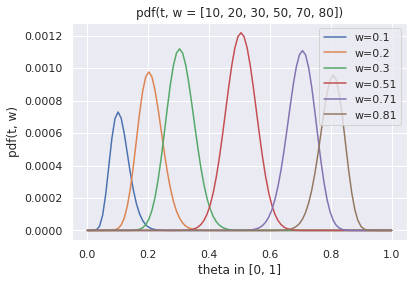

In [8]:
idxs = [10, 20, 30, 50, 70, 80]
for i in idxs:
    plt.plot(grid, pdf_tw[i], label=f'w={grid[i]:.2}')
plt.title(f'pdf(t, w = {idxs})')
plt.xlabel('theta in [0, 1]')
plt.ylabel('pdf(t, w)')
plt.legend();

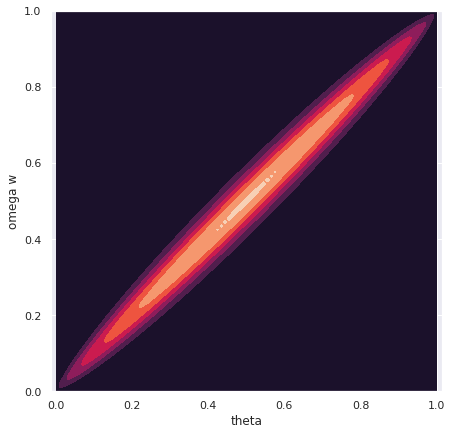

In [9]:
# contour plot of the prior distribution
X, Y = np.meshgrid(grid, grid)
plt.figure(figsize=(7,7))
plt.contourf(X, Y, pdf_tw)
plt.ylabel('omega w')
plt.xlabel('theta')
plt.axis('equal');

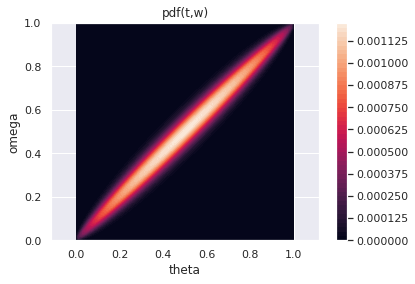

In [10]:
def show3df(Z, title=''):
    plt.contourf(X, Y, Z, 50)
    plt.colorbar()
    if title is not None:
        plt.title(title)
    plt.xlabel('theta')
    plt.ylabel('omega')
    plt.axis('equal');
#
show3df(pdf_tw, title='pdf(t,w)')

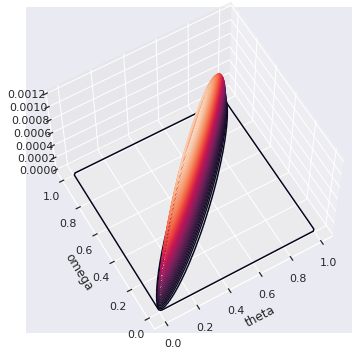

In [11]:
fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, pdf_tw, 50)
ax.set_xlabel('theta')
ax.set_ylabel('omega')
ax.view_init(elev=60, azim=-120)

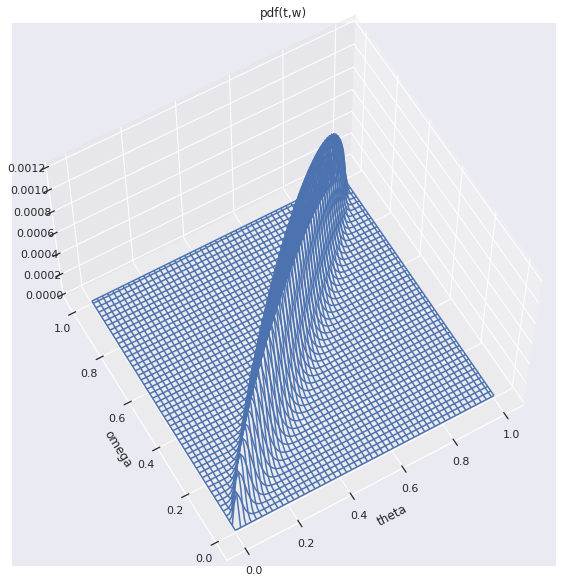

In [12]:
def wf3d(Z, title='', elev=60, azim=-120, fs=10):  # wireframe
    fig = plt.figure(figsize=(fs,fs))
    ax = plt.axes(projection='3d')
    ax.set_title(title if title is not None else 'wireframe')
    ax.plot_wireframe(X, Y, Z)
    ax.set_xlabel('theta')
    ax.set_ylabel('omega')
    ax.view_init(elev=elev, azim=azim)
#
wf3d(pdf_tw, title='pdf(t,w)')

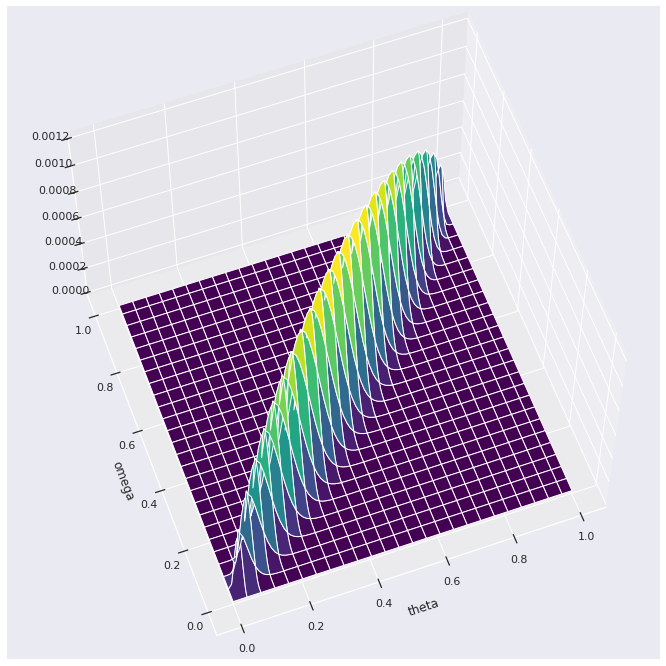

In [13]:
fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, pdf_tw, 
                rstride=4, cstride=4,
                cmap='viridis')
ax.set_xlabel('theta')
ax.set_ylabel('omega')
ax.view_init(elev=60, azim=-110)

#### Likelihood

- Prior: 
    $$
        w \sim Beta(Aw, Bw) \\
        K = 100 \\
        p(\theta, \omega) = Beta(\theta|a(\omega), b(\omega)) Beta(\omega|A_\omega, B_\omega)
    $$
    - Domain of beta() is approximated with grid
- Likelihood:
    $$
        y_i \sim Bernoulli(\theta) \\
        p(y_i | \theta) = \theta^{y_i} (1 - \theta)^{1-y_i}
    $$
- Posterior:
    $$
        p(\theta, \omega| Y) \approx  p(\theta|a, b) p(\omega|A_w, B_w) \prod_{i=1}^n p(y_i|\theta) \\
        = p(\theta, \omega) \prod_{i=1}^n p(y_i|\theta) 
    $$

In [14]:
print(f'y = {y}')
# pmf_y_given_t = 
pdf_y_given_t = np.empty_like(prior)
for i, w in enumerate(pdf_w):
    pdf_t_at_w = pdf_t_given_w[i]
    for j, (t,pt) in enumerate(zip(grid, pdf_t_at_w)):
        p_yi = 1
        for yi in y:
            p_yi *= t if yi else 1-t
        pdf_y_given_t[i][j] = p_yi
    pdf_y_given_t[i] /= pdf_y_given_t[i].sum()
#
likelihood = pdf_y_given_t

y = [1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.]


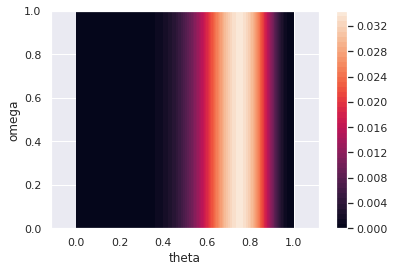

In [15]:
show3df(pdf_y_given_t)

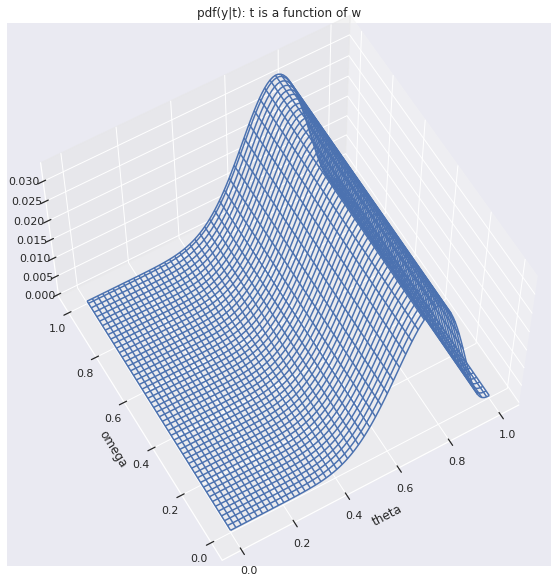

In [16]:
wf3d(pdf_y_given_t, title='pdf(y|t): t is a function of w')

#### Posterior

In [17]:
posterior = prior * likelihood
posterior /= posterior.sum()

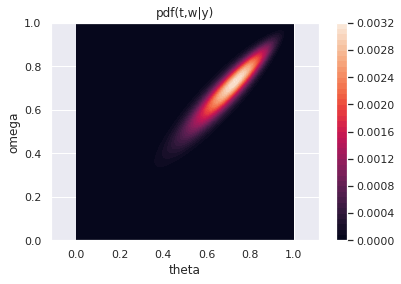

In [18]:
show3df(posterior, title='pdf(t,w|y)')

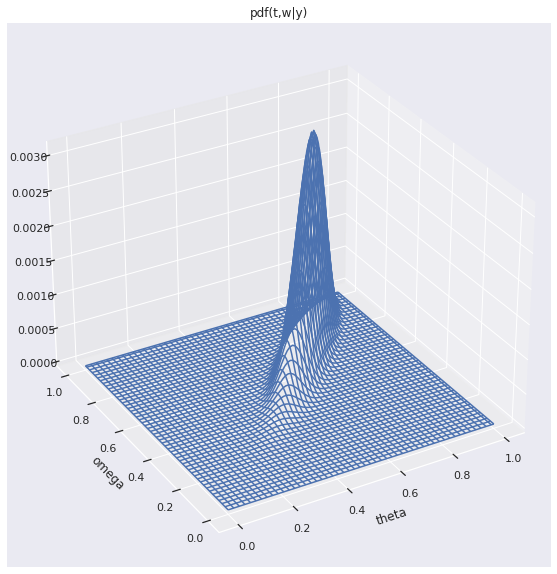

In [19]:
wf3d(posterior, title='pdf(t,w|y)', elev=30)

### Marginal Posteriors

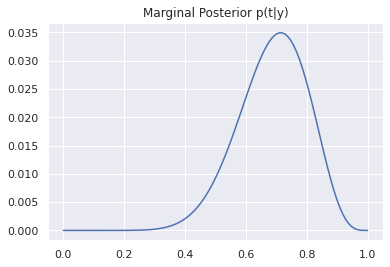

In [20]:
post_t = posterior.sum(axis=0)
plt.plot(grid, post_t)
plt.title('Marginal Posterior p(t|y)');

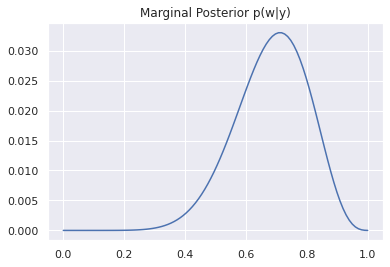

In [21]:
post_w = posterior.sum(axis=1)
plt.plot(grid, post_w)
plt.title('Marginal Posterior p(w|y)');

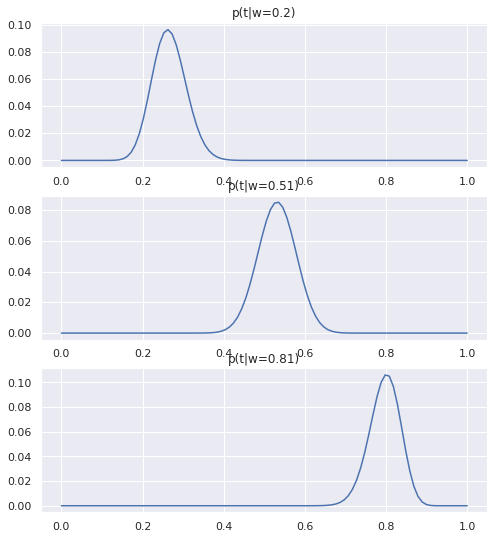

In [22]:
# posteriors, conditional at w=w0

iw0s = [20, 50, 80]
fig, axes = plt.subplots(len(iw0s), 1, figsize=(8, 3*len(iw0s)))
for iw, ax in zip(iw0s, axes.ravel()):
    p_t = posterior[iw]; p_t = p_t / p_t.sum()
    ax.plot(grid, p_t)
    ax.set_title(f'p(t|w={grid[iw]:.2})')
    pass

### Posterior via pymc3 with MCMC 

In [23]:
with pm.Model() as model:
    w = pm.Beta('w', alpha=Aw, beta=Bw)
    a, b = w*(K-2)+1, (1-w)*(K-2)+1  # (a,b) is determined at (w, K) 
    t = pm.Beta('t', alpha=a, beta=b)
    y = pm.Bernoulli('y', p=t, observed=y)
    trace = pm.sample(10000)

/home/yndk/.local/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t, w]


/home/yndk/.local/lib/python3.7/site-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
/home/yndk/.local/lib/python3.7/site-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
/home/yndk/.local/lib/python3.7/site-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
/home/yndk/.local/lib/python3.7/site-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 10 seconds.
The number of effective samples is smaller than 25% for some parameters.


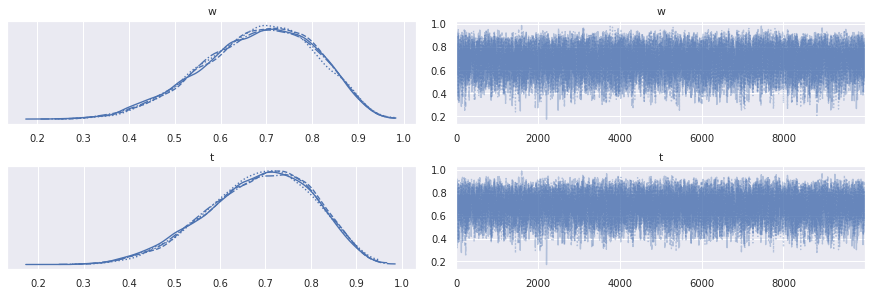

In [24]:
with model:
    az.plot_trace(trace)

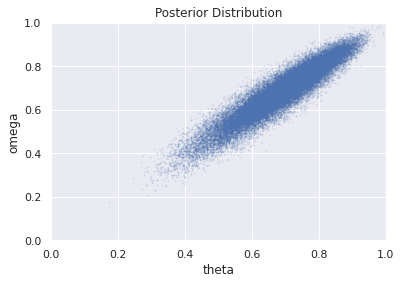

In [25]:
plt.scatter(trace['t'], trace['w'], alpha=.1, s=1)
plt.xlim([0,1])
plt.ylim([0,1])
plt.title('Posterior Distribution')
plt.xlabel('theta')
plt.ylabel('omega');

#### Exercise
- Perform expreiments for $K=6$, $A_\omega=20$, $B_\omega=20$.
- Describe how the assumption is different and how the result is different.

## Chapter 9.2 Multiple Coins from a Single Mint

- If there are S subjects altogether, then there are S+1 parameters ($t_1, ..., t_S$ and $\omega$) being estimated simultaneously.
- If our primary research interest is the overall effet of the tdrug, not the reactions of individual subjects, then we are most interested in the estimate of $\omega$.

### Posterior via grid approximation

- Suppose we have only two subjects in the same condition (i.e. two coins from the same mint).
- We want to estimate the biases $t_1$ and $t_2$ of the two subjects, and simultaneously estimate $\omega$ of the drug that influenced them.

### A realistic model with MCMC

#### Gamma Distribution
- Two parameters: shape $s$ and rate $r$
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html
- https://en.wikipedia.org/wiki/Gamma_distribution

In [26]:
shapes = [0.01, 0.1, 1, 1.5, 2.5, 10]
rates = [0.01, 0.02, 0.1, 0.2, 1]

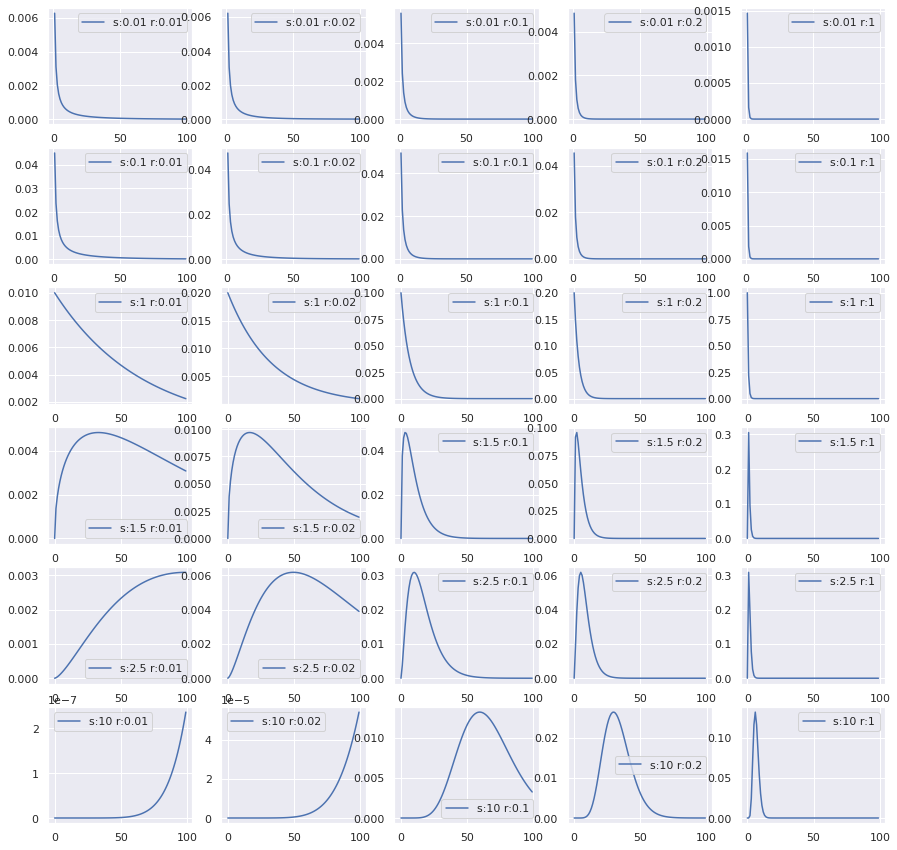

In [27]:
fig, axes = plt.subplots(len(shapes), len(rates), figsize=(15,15))
for i, shape in enumerate(shapes):
    for j, rate in enumerate(rates):
        ax = axes[i, j]
        scale = 1/rate  #
        g = stats.gamma(a=shape, scale=scale)
        x = np.linspace(0, 150, 100)
        ax.plot(g.pdf(x), label=f's:{shape} r:{rate}')
        ax.legend()

- [9.2.4 - Example: Therapeutic touch](#9.2.4---Example:-Therapeutic-touch)   
    - [Shrinkage](#Shrinkage)
- [9.5.1 - Example: Baseball batting abilities by position (subjects within categories)](#9.5.1---Example:-Baseball-batting-abilities-by-position)   

In [32]:
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from IPython.display import Image
from matplotlib import gridspec

%matplotlib inline

plt.style.use('seaborn-white')
color = '#87ceeb'

### 9.2.4 - Example: Therapeutic touch

In [28]:
df = pd.read_csv('data/TherapeuticTouchData.csv', dtype={'s':'category'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280 entries, 0 to 279
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   y       280 non-null    int64   
 1   s       280 non-null    category
dtypes: category(1), int64(1)
memory usage: 2.8 KB


In [29]:
df.head()

,y,s
0,1,S01
1,0,S01
2,0,S01
3,0,S01
4,0,S01


#### Figure 9.9

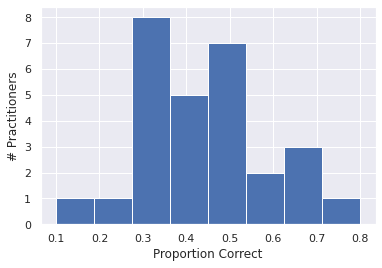

In [30]:
df_proportions = df.groupby('s')['y'].apply(lambda x: x.sum()/len(x))

ax = df_proportions.plot(kind='hist', bins=8)
ax.set(xlabel='Proportion Correct', ylabel='# Practitioners');

#### Model (Kruschke, 2015)

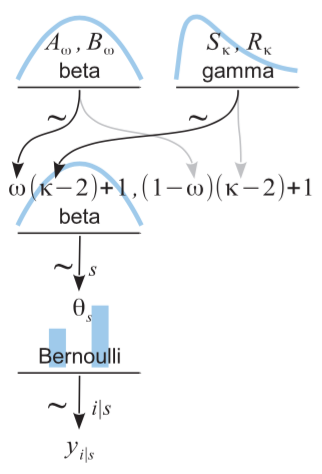

In [33]:
Image('images/fig9_7.png', width=200)

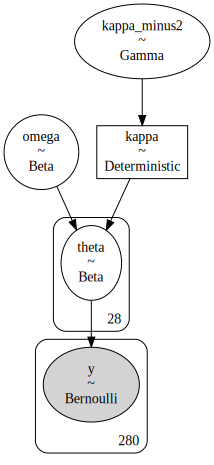

In [34]:
practitioner_idx = df.s.cat.codes.values
practitioner_codes = df.s.cat.categories
n_practitioners = practitioner_codes.size

with pm.Model() as hierarchical_model:
    omega = pm.Beta('omega', 1., 1.)
    kappa_minus2 = pm.Gamma('kappa_minus2', 0.01, 0.01)
    kappa = pm.Deterministic('kappa', kappa_minus2 + 2)
    
    theta = pm.Beta('theta', alpha=omega*(kappa-2)+1, beta=(1-omega)*(kappa-2)+1, shape=n_practitioners)
        
    y = pm.Bernoulli('y', theta[practitioner_idx], observed=df.y)    

pm.model_to_graphviz(hierarchical_model)

In [40]:
with hierarchical_model:
    trace = pm.sample(5000, cores=4, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, kappa_minus2, omega]


/home/yndk/.local/lib/python3.7/site-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
/home/yndk/.local/lib/python3.7/site-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
/home/yndk/.local/lib/python3.7/site-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 19 seconds.
The number of effective samples is smaller than 10% for some parameters.


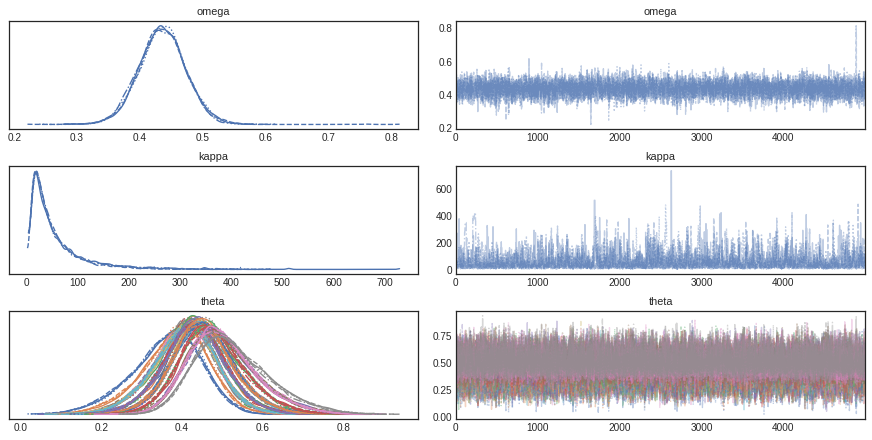

In [41]:
az.plot_trace(trace, ['omega','kappa', 'theta']);

In [43]:
az.summary(trace)
# Note that theta is indexed starting with 0 and not 1, as is the case in Kruschke (2015).

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
omega,0.435,0.038,0.366,0.505,0.001,0.000,5470.0,5419.0,5420.0,8545.0,1.0
kappa_minus2,54.790,57.835,2.134,157.143,1.617,1.143,1280.0,1280.0,1392.0,2331.0,1.0
kappa,56.790,57.835,4.134,159.143,1.617,1.143,1280.0,1280.0,1392.0,2331.0,1.0
theta[0],0.361,0.087,0.189,0.516,0.001,0.001,4252.0,4252.0,4513.0,7535.0,1.0
theta[1],0.384,0.084,0.219,0.536,0.001,0.001,7205.0,7205.0,7518.0,8685.0,1.0
theta[2],0.407,0.080,0.246,0.552,0.001,0.001,10778.0,10778.0,10844.0,9235.0,1.0
theta[3],0.407,0.079,0.254,0.557,0.001,0.001,11306.0,11306.0,11439.0,9898.0,1.0
theta[4],0.407,0.080,0.255,0.556,0.001,0.001,10436.0,10436.0,10678.0,10018.0,1.0
theta[5],0.407,0.080,0.249,0.556,0.001,0.001,10868.0,10868.0,11131.0,9156.0,1.0
theta[6],0.406,0.080,0.247,0.552,0.001,0.001,10221.0,10221.0,10517.0,9100.0,1.0


#### Figure 9.10 - Marginal posterior distributions

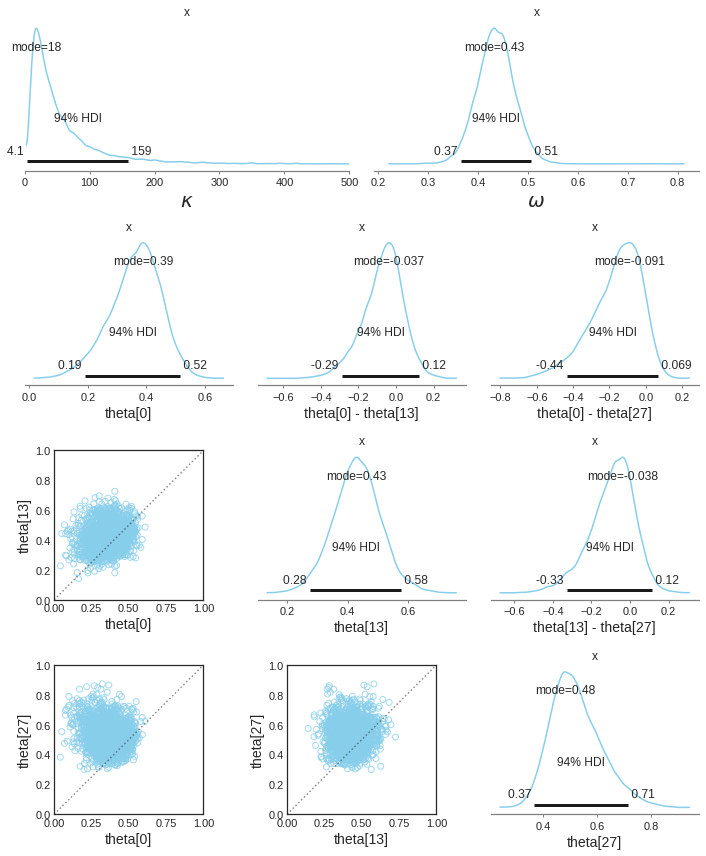

In [45]:
plt.figure(figsize=(10,12))

# Define gridspec
gs = gridspec.GridSpec(4, 6)
ax1 = plt.subplot(gs[0,:3])
ax2 = plt.subplot(gs[0,3:])
ax3 = plt.subplot(gs[1,:2])
ax4 = plt.subplot(gs[1,2:4])
ax5 = plt.subplot(gs[1,4:6])
ax6 = plt.subplot(gs[2,:2])                     
ax7 = plt.subplot(gs[2,2:4])
ax8 = plt.subplot(gs[2,4:6])
ax9 = plt.subplot(gs[3,:2])
ax10 = plt.subplot(gs[3,2:4])
ax11 = plt.subplot(gs[3,4:6])

# thetas and theta pairs to plot
thetas = (0, 13, 27)
theta_pairs = ((0,13),(0,27),(13,27))

font_d = {'size':14}

# kappa & omega posterior plots
for var, ax in zip(['kappa', 'omega'], [ax1, ax2]):
    az.plot_posterior(trace[var], point_estimate='mode', ax=ax, color=color, round_to=2)
    ax.set_xlabel('$\{}$'.format(var), fontdict={'size':20, 'weight':'bold'})
ax1.set(xlim=(0,500))

# theta posterior plots
for var, ax in zip(thetas,[ax3, ax7, ax11]):
    az.plot_posterior(trace['theta'][:,var], point_estimate='mode', ax=ax, color=color)
    ax.set_xlabel('theta[{}]'.format(var), fontdict=font_d)

# theta scatter plots
for var, ax in zip(theta_pairs,[ax6, ax9, ax10]):
    ax.scatter(trace['theta'][::10,var[0]], trace['theta'][::10,var[1]], alpha=0.75, color=color, facecolor='none')
    ax.plot([0, 1], [0, 1], ':k', transform=ax.transAxes, alpha=0.5)
    ax.set_xlabel('theta[{}]'.format(var[0]), fontdict=font_d)
    ax.set_ylabel('theta[{}]'.format(var[1]), fontdict=font_d)
    ax.set(xlim=(0,1), ylim=(0,1), aspect='equal')

# theta posterior differences plots
for var, ax in zip(theta_pairs,[ax4, ax5, ax8]):
    az.plot_posterior(trace['theta'][:,var[0]]-trace['theta'][:,var[1]], point_estimate='mode', ax=ax, color=color)
    ax.set_xlabel('theta[{}] - theta[{}]'.format(*var), fontdict=font_d)

plt.tight_layout()

### Shrinkage

Let's create a model with just the theta estimations per practitioner, without the influence of a higher level distribution. Then we can compare the theta values with the hierarchical model above.

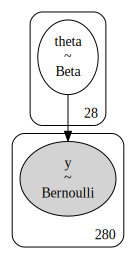

In [46]:
with pm.Model() as unpooled_model:
    
    theta = pm.Beta('theta', 1, 1, shape=n_practitioners)
        
    y = pm.Bernoulli('y', theta[practitioner_idx], observed=df.y)
    
pm.model_to_graphviz(unpooled_model)

In [47]:
with unpooled_model:
    unpooled_trace = pm.sample(5000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


/home/yndk/.local/lib/python3.7/site-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
/home/yndk/.local/lib/python3.7/site-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
/home/yndk/.local/lib/python3.7/site-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
/home/yndk/.local/lib/python3.7/site-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 6 seconds.


Here we concatenate the trace results (thetas) from both models into a dataframe. Next we shape the data into a format that we can use with Seaborn's pointplot.

In [49]:
df_shrinkage = (pd.concat([az.summary(unpooled_trace).iloc[:,0],
                           az.summary(trace).iloc[3:,0]],
                          axis=1)
                .reset_index())
df_shrinkage.columns = ['theta', 'unpooled', 'hierarchical']
df_shrinkage = pd.melt(df_shrinkage, 'theta', ['unpooled', 'hierarchical'], var_name='Model')
df_shrinkage.head()

,theta,Model,value
0,theta[0],unpooled,0.167
1,theta[1],unpooled,0.250
2,theta[2],unpooled,0.334
3,theta[3],unpooled,0.333
4,theta[4],unpooled,0.334


In [51]:
df_shrinkage

,theta,Model,value
0,theta[0],unpooled,0.167
1,theta[1],unpooled,0.250
2,theta[2],unpooled,0.334
3,theta[3],unpooled,0.333
4,theta[4],unpooled,0.334
5,theta[5],unpooled,0.332
6,theta[6],unpooled,0.333
7,theta[7],unpooled,0.334
8,theta[8],unpooled,0.333
9,theta[9],unpooled,0.333


The below plot shows that the theta estimates on practitioner level are pulled towards the group mean of the hierarchical model.

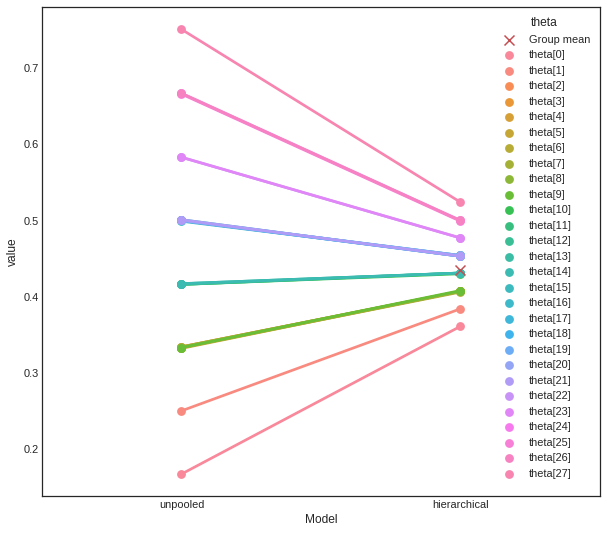

In [55]:
plt.figure(figsize=(10,9))
plt.scatter(1, az.summary(trace)['mean']['omega'], s=100, c='r', marker='x', zorder=999, label='Group mean')
sns.pointplot(x='Model', y='value', hue='theta', data=df_shrinkage);

### 9.5.1 - Example: Baseball batting abilities by position

In [56]:
df2 = pd.read_csv('data/BattingAverage.csv', usecols=[0,1,2,3], dtype={'PriPos':'category'})
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 948 entries, 0 to 947
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   Player  948 non-null    object  
 1   PriPos  948 non-null    category
 2   Hits    948 non-null    int64   
 3   AtBats  948 non-null    int64   
dtypes: category(1), int64(2), object(1)
memory usage: 23.6+ KB


The DataFrame contains records for 948 players in the 2012 regular season of Major League Baseball.
- One record per player
- 9 primary field positions

In [57]:
df2['BatAv'] = df2.Hits.divide(df2.AtBats)
df2.head(10)

,Player,PriPos,Hits,AtBats,BatAv
0,Fernando Abad,Pitcher,1,7,0.142857
1,Bobby Abreu,Left Field,53,219,0.242009
2,Tony Abreu,2nd Base,18,70,0.257143
3,Dustin Ackley,2nd Base,137,607,0.225700
4,Matt Adams,1st Base,21,86,0.244186
5,Nathan Adcock,Pitcher,0,1,0.000000
6,Jeremy Affeldt,Pitcher,0,1,0.000000
7,Brandon Allen,1st Base,2,20,0.100000
8,Yonder Alonso,1st Base,150,549,0.273224
9,Jose Altuve,2nd Base,167,576,0.289931


In [58]:
# Batting average by primary field positions calculated from the data
df2.groupby('PriPos')['Hits','AtBats'].sum().pipe(lambda x: x.Hits/x.AtBats)

PriPos
1st Base        0.258851
2nd Base        0.255676
3rd Base        0.265036
Catcher         0.247404
Center Field    0.263513
Left Field      0.259077
Pitcher         0.129148
Right Field     0.263555
Shortstop       0.255186
dtype: float64

#### Model (Kruschke, 2015)

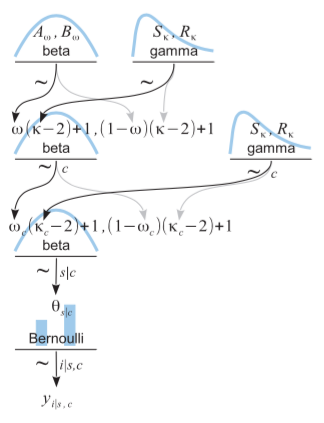

In [59]:
Image('images/fig9_13.png', width=300)

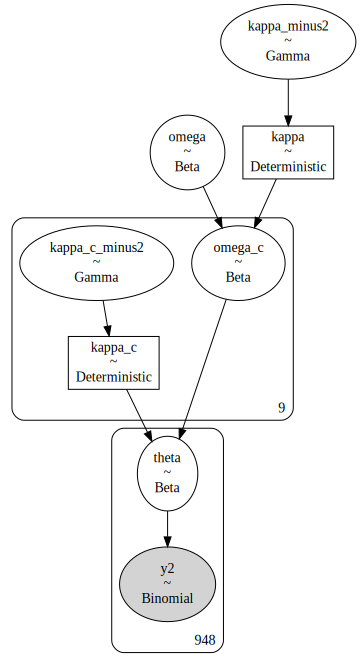

In [60]:
pripos_idx = df2.PriPos.cat.codes.values
pripos_codes = df2.PriPos.cat.categories
n_pripos = pripos_codes.size

# df2 contains one entry per player
n_players = df2.index.size

with pm.Model() as hierarchical_model2:
    # Hyper parameters
    omega = pm.Beta('omega', 1, 1)
    kappa_minus2 = pm.Gamma('kappa_minus2', 0.01, 0.01)
    kappa = pm.Deterministic('kappa', kappa_minus2 + 2)
    
    # Parameters for categories (Primary field positions)
    omega_c = pm.Beta('omega_c',
                       omega*(kappa-2)+1, (1-omega)*(kappa-2)+1,
                       shape = n_pripos)
    
    kappa_c_minus2 = pm.Gamma('kappa_c_minus2',
                              0.01, 0.01,
                              shape = n_pripos)
    kappa_c = pm.Deterministic('kappa_c', kappa_c_minus2 + 2)
        
    # Parameter for individual players
    theta = pm.Beta('theta',
                     omega_c[pripos_idx]*(kappa_c[pripos_idx]-2)+1,
                    (1-omega_c[pripos_idx])*(kappa_c[pripos_idx]-2)+1,
                     shape = n_players)
    
    y2 = pm.Binomial('y2', n=df2.AtBats.values, p=theta, observed=df2.Hits)

pm.model_to_graphviz(hierarchical_model2)

In [61]:
with hierarchical_model2:
    trace2 = pm.sample(3000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, kappa_c_minus2, omega_c, kappa_minus2, omega]


/home/yndk/.local/lib/python3.7/site-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
/home/yndk/.local/lib/python3.7/site-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
/home/yndk/.local/lib/python3.7/site-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
/home/yndk/.local/lib/python3.7/site-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 46 seconds.
The number of effective samples is smaller than 10% for some parameters.


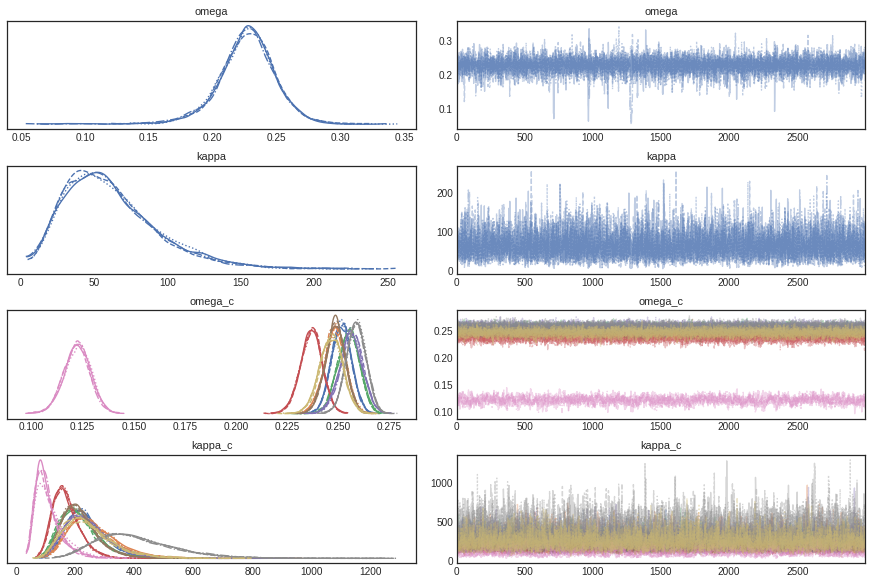

In [63]:
az.plot_trace(trace2, ['omega', 'kappa', 'omega_c', 'kappa_c']);

#### Figure 9.17

#### Posterior distribution of hyper parameter omega after sampling.

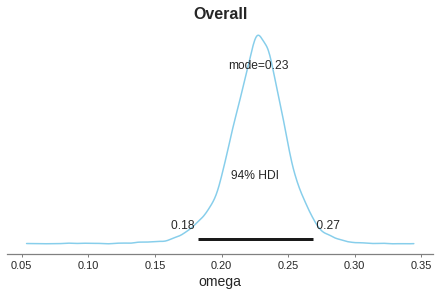

In [64]:
az.plot_posterior(trace2['omega'], point_estimate='mode', color=color)
plt.title('Overall', fontdict={'fontsize':16, 'fontweight':'bold'})
plt.xlabel('omega', fontdict={'fontsize':14});

#### Posterior distributions of the omega_c parameters after sampling.

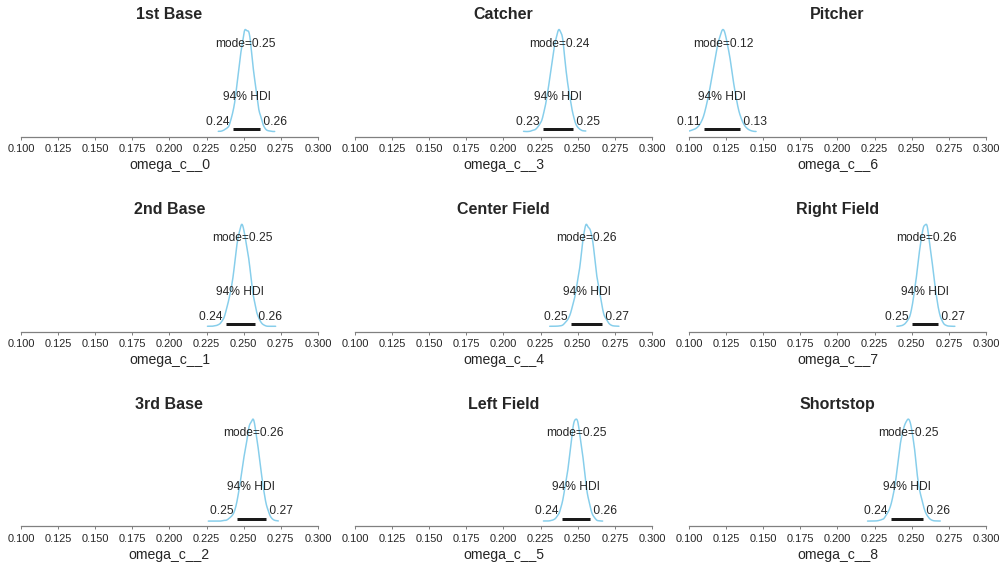

In [66]:
fig, axes = plt.subplots(3,3, figsize=(14,8))

for i, ax in enumerate(axes.T.flatten()):
    az.plot_posterior(trace2['omega_c'][:,i], ax=ax, point_estimate='mode', color=color)
    ax.set_title(pripos_codes[i], fontdict={'fontsize':16, 'fontweight':'bold'})
    ax.set_xlabel('omega_c__{}'.format(i), fontdict={'fontsize':14})
    ax.set_xlim(0.10,0.30)

plt.tight_layout(h_pad=3)